In [1]:
import copy
import pandas
import warnings
import subprocess
from matplotlib import pyplot as plt
import os
import sys
from scipy import stats
import pprint
from IPython import display
import math

sys.path.insert(0, "../src")

from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

csv = "../datasets/genny2/perf_criteria_threads.csv"


/home/mark/.local/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
# medical_workload_status_50_50_unencrypted
#medical_workload_credit_cards_100_0_unencrypted
#medical_workload_diagnosis_100_0
def parse_task_name(tn): 
    tn = tn.replace("credit_cards", "creditcards")
    if tn.startswith("medical_workload_load"):
        p = tn.split("_")
        threads = int(p[3][1:])

        return ("all", 0, 0, threads)

    p = tn.split("_")
    if len(p) < 5:
        raise ValueError(tn)
    column = p[2]
    read = p[3]
    write = p[4]
    threads = int(p[5][1:])
    return (column, read, write, threads)

print(parse_task_name("medical_workload_credit_cards_50_50_t16"))
print(parse_task_name("medical_workload_credit_cards_50_50_t16_unencrypted"))
print(parse_task_name("medical_workload_load_t16"))

# print(parse_task_name("medical_workload_status_50_50_unencrypted"))


('creditcards', '50', '50', 16)
('creditcards', '50', '50', 16)
('all', 0, 0, 16)


In [4]:

# def extract_city_name(df):
#     """
#     Chicago, IL -> Chicago for city_name column
#     """
#     #df["city_name"] = df["city_and_code"].str.split(",").str.get(0)
#     pd["test_type"]  = pd["Task Name"].str.split("_").get(0)

#     return df

# medical_workload_status_50_50_unencrypted
#medical_workload_credit_cards_100_0_unencrypted
#medical_workload_diagnosis_100_0

def get_test_type(t) :
    if "inserts" in t:
        return "inserts"
    if "update" in t:
        return "update"
    if "Crud" in t:
        return "crud"
    return "query"

def add_columns(df):
    # df = df.query(f"Test == 'InsertActor.load.inserts'")

    # df["test_type"] = df["Task Name"].apply(lambda x : x.split("_")[0])
    df["encrypted_type"] = df["Task Name"].apply(lambda x : "unencrypted" if "unencrypted" in x else "encrypted" )

    df["query_column"] = df["Task Name"].apply(lambda x : parse_task_name(x)[0] )

    df["read_percentage"] = df["Task Name"].apply(lambda x : parse_task_name(x)[1] )
    df["write_percentage"] = df["Task Name"].apply(lambda x : parse_task_name(x)[2] )

    df["threads"] = df["Task Name"].apply(lambda x : parse_task_name(x)[3] )

    df["test_type"] = df["Test"].apply(lambda x : get_test_type(x) )

    df["topo_type"] = df["Topology"].apply(lambda x : "replset" if "replSet" in x else "sharding" )

    df["Latency95thPercentileMillis"] = df["Latency95thPercentile"] / 1000000
    df["AverageLatencyMillis "] = df["AverageLatency"] / 1000000

    return df


# Note: CRUD = inserts + query + update
df = pandas.read_csv(csv)
df = df.query("Test != 'InsertActor.Crud'")
df["version"] = "60"
df = add_columns(df)
# df_60 = df_60.query("encrypted_type != 'unencrypted'")

# df = pandas.concat([df_60, df_70, df_60_unencrypted, df_70_unencrypted], ignore_index=True)

# a = pd["Task Name"].str.split("_").get(0)

#pd = pd.pipe(extract_city_name)
df.to_csv("/tmp/summary.csv")
# pd["AverageLatency"].plot()
# df



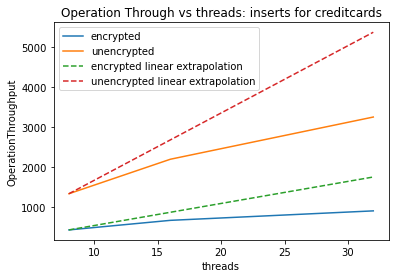

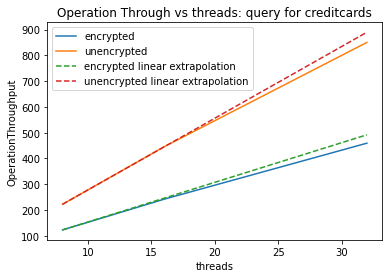

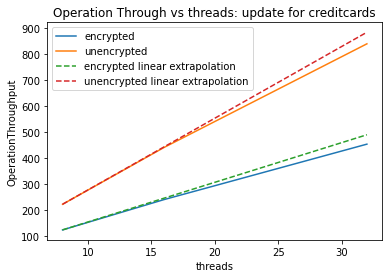

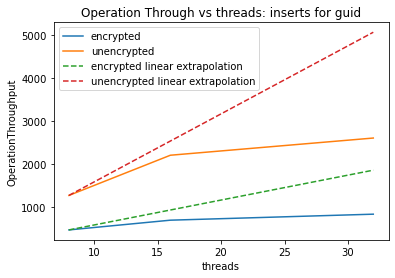

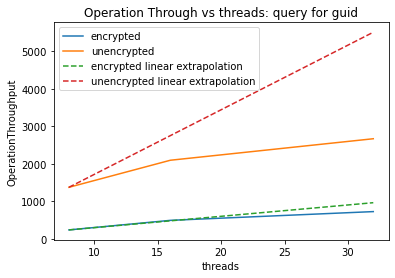

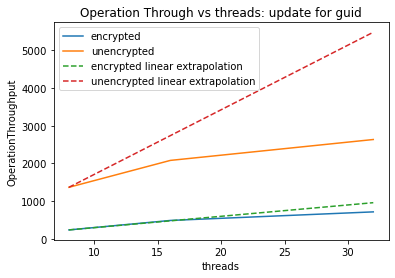

In [7]:
# Make a pivot table for average latency for load and graph it

csv_tmp = "/tmp/summary.csv"
# csv_tmp = "../datasets/genny2/perf_criteria_threads.csv"

def graph_throughput(test_type, query_column):
    query = f"query_column == '{query_column}' and test_type == '{test_type}'" # & Experiment == 'es3'"
    pd = pandas.read_csv(csv_tmp)

    # un_pd1 = pd_orig.query("QueryNumber == 'load' & Experiment == 'es1'")
    #un_piv_orig = un_pd1_orig.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")

    pd = pd.query(query)
    pd
    # piv = pd.pivot(index='encrypted_type', columns="threads", values="AverageLatency")
    # piv = pd.pivot(index='threads', columns="encrypted_type", values="AverageLatency")
    piv = pd.pivot(index='threads', columns="encrypted_type", values="OperationThroughput")

    unenc_ops_per_thread = piv["unencrypted"].iloc[0] / 8

    enc_ops_per_thread = piv["encrypted"].iloc[0] / 8
    # piv["extrapolation"] = df.apply(lambda row: row["threads"] * enc_ops_per_thread, axis=1)

    # piv["extrapolation"] = piv["threads"] * enc_ops_per_thread
    x = [8, 16, 32]


    piv["encrypted_linear"] = [a * enc_ops_per_thread for a in x] #[8* enc_ops_per_thread, 16* enc_ops_per_thread, 32* enc_ops_per_thread]
    piv["unencrypted_linear"] = [a * unenc_ops_per_thread for a in x]
    piv

    # piv.plot(title="ORIG ES2 Load: Average Latency", ylabel="Average Latency")
    # piv.plot(title="ORIG ES2 Load: Average Latency", ylabel="OperationThroughput")

    plt.figure()
    plt.xlabel('threads')
    plt.ylabel('OperationThroughput')
    plt.title(f"Operation Through vs threads: {test_type} for {query_column}")

    # piv.plot(title="ORIG ES2 Load: Average Latency", ylabel="OperationThroughput")
    plt.plot(x, piv["encrypted"], label="encrypted")
    plt.plot(x, piv["unencrypted"], label="unencrypted")
    plt.plot(x, piv["encrypted_linear"],  label="encrypted linear extrapolation", linestyle="dashed")
    plt.plot(x, piv["unencrypted_linear"],  label="unencrypted linear extrapolation", linestyle="dashed")

    plt.legend()

graph_throughput("inserts", "creditcards")
graph_throughput("query", "creditcards")
graph_throughput("update", "creditcards")


graph_throughput("inserts", "guid")
graph_throughput("query", "guid")
graph_throughput("update", "guid")

# piv_new.plot(title="NEW ES2 Load: Average Latency", ylabel="Average Latency")

In [16]:
csv_tmp = "/tmp/summary.csv"
pd = pandas.read_csv(csv_tmp)
pd[["query_column", "test_type", "encrypted_type", "threads", "AverageLatency", "OperationThroughput"]]

# def graph_throughput(test_type, query_column):
# query_column = 
# query = f"query_column == '{query_column}' and test_type == '{test_type}'" # & Experiment == 'es3'"
# pd = pandas.read_csv(csv_tmp)

# # un_pd1 = pd_orig.query("QueryNumber == 'load' & Experiment == 'es1'")
# #un_piv_orig = un_pd1_orig.pivot(index='ContentionFactor', columns="ThreadCount", values="AverageLatencyMillis")

# pd = pd.query(query)
# pd
# # piv = pd.pivot(index='encrypted_type', columns="threads", values="AverageLatency")
# # piv = pd.pivot(index='threads', columns="encrypted_type", values="AverageLatency")
# piv = pd.pivot(index='threads', columns="encrypted_type", values="OperationThroughput")

,query_column,test_type,encrypted_type,threads,AverageLatency,OperationThroughput
0,creditcards,inserts,encrypted,16,2.237381e+07,677.855347
1,creditcards,update,encrypted,16,3.010948e+07,239.331088
2,creditcards,query,encrypted,16,4.957046e+06,241.956756
3,creditcards,inserts,unencrypted,16,5.792615e+06,2200.007040
4,creditcards,update,unencrypted,16,3.936148e+06,440.361286
5,creditcards,query,unencrypted,16,1.291024e+06,445.139067
6,creditcards,inserts,encrypted,32,3.339044e+07,913.740185
7,creditcards,update,encrypted,32,3.289089e+07,453.231370
8,creditcards,query,encrypted,32,5.129375e+06,459.247635
9,creditcards,inserts,unencrypted,32,6.604589e+06,3251.419245


In [4]:
def title_case(name):
    # type: (str) -> str
    """Return a CapitalCased version of a string."""

    # Only capitalize the last part of a fully-qualified name
    pos = name.rfind("::")
    if pos > -1:
        return name[:pos + 2] + name[pos + 2:pos + 3].upper() + name[pos + 3:]

    return name[0:1].upper() + name[1:]


In [5]:
df = pandas.DataFrame()

df[0]  = [1,2,3]

df[1] = [4,5,6]
df


,0,1
0,1,4
1,2,5
2,3,6


In [5]:

def get_numbers(topo, column, test, test_type, enc_type, version):
    query = f"topo_type == '{topo}' & query_column == '{column}' & read_percentage == {test[0]} & write_percentage == {test[1]} & test_type == '{test_type}' & encrypted_type == '{enc_type}' & version == {version}"
    rows = df.query(query)
    if rows.empty:
        # raise ValueError("No Rows: " + str(query))
        return ("Missing", "Missing")
    rc = rows.size / len(df.columns)
    if rc > 1:
        raise ValueError("Too many: %s - %s " % (rc, query))
    #assert row count
    r = rows

    ops_sec = rows["OperationThroughput"]
    p95_lat = rows["Latency95thPercentile"] / 1000000


    if  math.isnan(ops_sec) :
        raise ValueError("NAN is bad %s, %s - %s - %s" % (ops_sec, p95_lat, query , r))

    return (ops_sec.iloc[0], p95_lat.iloc[0])

# Bulk
# - 60 rs
# -- latency , ops_sec
# - 70 rs
# -- latency , ops_sec
# - 60 sharding
# -- latency , ops_sec
# - 70 sharding
# -- latency , ops_sec

rows = [
    ("creditcards", (50, 50)),
    ("diagnosis", (50, 50)),
    ("guid", (50, 50)),
    ("states", (50, 50)),
    ("status", (50, 50)),

    ("creditcards", (95, 5)),
    ("diagnosis", (95, 5)),
    ("guid", (95, 5)),
    ("states", (95, 5)),
    ("status", (95, 5)),

    ("creditcards", (100,0)),
    ("diagnosis", (100,0)),
    ("guid", (100,0)),
    ("states", (100,0)),
    ("status", (100,0)),

    ("load", (50, 50)),
]


In [6]:
df = pandas.read_csv("/tmp/summary.csv")

topo = "sharding"
dfr = None
for row in rows:
    query_cat = row[0]
    (read_percentage, write_percentage) = row[1]

    data = {}
    data["test"] = f"{read_percentage}% Read, {write_percentage}% Update"
    data["column"] = title_case(query_cat)

    for fsm_type in ["query", "update"]:
        q_type = "inserts" if query_cat == "load" else fsm_type
        if query_cat == "load" and fsm_type == "update":
            continue

        # No results for write_percentage == 0
        if write_percentage == 0 and fsm_type == "update":
            continue

        for version in [60, 70]:
            query_name = "creditcards" if query_cat == "load" else query_cat
            numbers = get_numbers(topo, query_name, row[1], q_type, "encrypted", version)

            (ops_sec, p95_lat) = numbers


            ops_quality = "unknown"
            latency_quality = "unknown"

            if ops_sec != "Missing":
                ops_sec = round(float(ops_sec))
                p95_lat = round(float(p95_lat))

                ops_quality = "bad"
                latency_quality = "bad"
                if query_cat == "load":
                    if ops_sec > 500:
                        ops_quality = "good"
                        latency_quality = "good"
                else:
                    if (read_percentage == 100 and p95_lat < 50) or \
                        (read_percentage == 95 and p95_lat < 55) or \
                        (read_percentage == 50 and p95_lat < 75):
                            ops_quality = "good"
                            latency_quality = "good"

            data["fsm"] = fsm_type

            data[f"{version}_p95"] = str(p95_lat) + "ms" if p95_lat != "Missing" else "Missing"
            data[f"{version}_ops"] = ops_sec

        sdf = pandas.DataFrame(index = [0], data=data)

        if dfr is None:
            dfr = sdf
        else:
            dfr = pandas.concat([dfr, sdf], ignore_index=True)

dfr.to_csv("/tmp/summary2.csv")
dfr

,test,column,fsm,60_p95,60_ops,70_p95,70_ops
0,"50% Read, 50% Update",Creditcards,query,173ms,45,22ms,204
1,"50% Read, 50% Update",Creditcards,update,238ms,44,36ms,202
2,"50% Read, 50% Update",Diagnosis,query,310ms,26,7ms,94
3,"50% Read, 50% Update",Diagnosis,update,365ms,26,31ms,93
4,"50% Read, 50% Update",Guid,query,71ms,95,3ms,510
5,"50% Read, 50% Update",Guid,update,147ms,94,37ms,506
6,"50% Read, 50% Update",States,query,Missing,Missing,Missing,Missing
7,"50% Read, 50% Update",States,update,Missing,Missing,Missing,Missing
8,"50% Read, 50% Update",Status,query,Missing,Missing,Missing,Missing
9,"50% Read, 50% Update",Status,update,Missing,Missing,Missing,Missing


In [8]:

output = """<html>
<style>
.good {
  background-color: lightgreen;
}
.bad {
  background-color: lightcoral;
}
</style>
<body><table>

<tr><th>Test</th>
<th>FSM</th>
<th colspan="4">1 Shard</th>
</tr>
<tr><th>Test</th>
<th>FSM</th>
<th colspan="2">MongoDB Non-Optimized</th>
<th colspan="2">Experimental 7.0</th>
</tr>

<tr><th>Test</th>
<th>FSM</th>
<th>Ops</th>
<th>P95</th>
<th>Ops</th>
<th>P95</th>
</tr>
"""

topo = "sharding"
for row in rows:

    for fsm_type in ["query", "update"]:
        query_cat = row[0]
        (read_percentage, write_percentage) = row[1]

        q_type = "inserts" if query_cat == "load" else fsm_type
        if query_cat == "load" and fsm_type == "update":
            continue

        # No results for write_percentage == 0
        if write_percentage == 0 and fsm_type == "update":
            continue


        output += "<tr>"
        output += f"<td>{title_case(query_cat)} {read_percentage}% Read, {write_percentage}% Update</td>"
        output += f"<td>{fsm_type}</td>"

        for version in [60, 70]:
            query_name = "creditcards" if query_cat == "load" else query_cat

            # numbers = get_numbers(topo, query_name, row[1], q_type, "encrypted", version)
            numbers = get_numbers(topo, query_name, row[1], q_type, "unencrypted", version)
            #print(numbers)

            (ops_sec, p95_lat) = numbers

            ops_quality = "unknown"
            latency_quality = "unknown"

            if ops_sec != "Missing":
                ops_sec = round(float(ops_sec))
                p95_lat = round(float(p95_lat))

                ops_quality = "bad"
                latency_quality = "bad"
                if query_cat == "load":
                    if ops_sec > 500:
                        ops_quality = "good"
                        latency_quality = "good"
                else:
                    if (read_percentage == 100 and p95_lat < 50) or \
                        (read_percentage == 95 and p95_lat < 55) or \
                        (read_percentage == 50 and p95_lat < 75):
                            ops_quality = "good"
                            latency_quality = "good"

            output += f"<td class='{ops_quality}'>{ops_sec}</td><td class='{latency_quality}'>{p95_lat}</td>"
        output += "</tr>"

output += "</table></body></html>"

# output

display.HTML(output)

In [91]:
# df = pandas.read_csv("/tmp/summary.csv")

# def get_numbers(topo, column, test, test_type, enc_type, version):
#     query = f"topo_type == '{topo}' & query_column == '{column}' & read_percentage == {test[0]} & write_percentage == {test[1]} & test_type == '{test_type}' & encrypted_type == '{enc_type}' & version == {version}"
#     rows = df.query(query)
#     if rows.empty:
#         # raise ValueError("No Rows: " + str(query))
#         return ("Not Available", "Not Available")
#     rc = rows.size / len(df.columns)
#     if rc > 1:
#         raise ValueError("Too many: %s - %s " % (rc, query))
#     #assert row count
#     r = rows

#     ops_sec = rows["OperationThroughput"]
#     p95_lat = rows["Latency95thPercentile"] / 1000000

#     return (ops_sec.iloc[0], p95_lat.iloc[0])


# # Bulk
# # - 60 rs
# # -- latency , ops_sec
# # - 70 rs
# # -- latency , ops_sec
# # - 60 sharding
# # -- latency , ops_sec
# # - 70 sharding
# # -- latency , ops_sec

# rows = [
#     ("load", (50, 50)),
#     ("creditcards", (50, 50)),
#     ("diagnosis", (50, 50)),
#     ("guid", (50, 50)),
#     ("states", (50, 50)),
#     ("status", (50, 50)),
# ]

# output = """<html>
# <style>
# .good {
#   background-color: lightgreen;
# }
# .bad {
#   background-color: lightcoral;
# }
# </style>
# <body><table>

# <tr><th>Test</th>
# <th colspan="4">Replica Set</th>
# <th colspan="4">1 Shard</th>
# </tr>
# <tr><th>Test</th>
# <th colspan="2">MongoDB Non-Optimized</th>
# <th colspan="2">Experimental 7.0</th>
# <th colspan="2">MongoDB Non-Optimized</th>
# <th colspan="2">Experimental 7.0</th>
# </tr>
# <tr><th>Test</th>
# <th>Ops</th>
# <th>P95</th>
# <th>Ops</th>
# <th>P95</th>
# <th>Ops</th>
# <th>P95</th>
# <th>Ops</th>
# <th>P95</th>
# </tr>
# """

# for row in rows:
#     output += "<tr>"
#     query_cat = row[0]
#     (read_percentage, write_percentage) = row[1]
#     output += f"<td>{title_case(query_cat)} {read_percentage}% Read, {write_percentage}% Update</td>"
#     for topo in ["replset", "sharding"]:
#         for version in [60, 70]:
#             q_type = "inserts" if query_cat == "load" else "query"
#             query_name = "creditcards" if query_cat == "load" else query_cat
#             numbers = get_numbers(topo, query_name, row[1], q_type, "encrypted", version)
#             #print(numbers)

#             (ops_sec, p95_lat) = numbers

#             ops_quality = "unknown"
#             latency_quality = "unknown"

#             if ops_sec != "Not Available":
#                 ops_sec = round(float(ops_sec))
#                 p95_lat = round(float(p95_lat))

#                 ops_quality = "bad"
#                 latency_quality = "bad"
#                 if query_cat == "load":
#                     if ops_sec > 500:
#                         ops_quality = "good"
#                         latency_quality = "good"
#                 else:
#                     if (read_percentage == 100 and p95_lat < 50) or \
#                         (read_percentage == 95 and p95_lat < 55) or \
#                         (read_percentage == 50 and p95_lat < 75):
#                             ops_quality = "good"
#                             latency_quality = "good"

#             output += f"<td class='{ops_quality}'>{ops_sec}</td><td class='{latency_quality}'>{p95_lat}</td>"
#     output += "</tr>"

# output += "</table></body></html>"

# # output

# display.HTML(output)


In [42]:
# df = pandas.read_csv("/tmp/summary.csv")
# #df

# topos = ["replset", "sharding"]
# columns = [ 'creditcards', 'diagnosis', 'guid', 'states', 'status']
# # tests = [(0,0), (100,0), (95, 5), (50,50)]
# test_types = ["insert", "query"]
# tests = [(100,0), (95, 5), (50,50)]
# enc_types = ["unencrypted", "encrypted"]

# #df

# r = None

# enc_type = "encrypted"
# test_type = "query"
# version = 60
# for topo in topos:
#     for column in columns:
#         for test in tests:
#             query = f"topo_type == '{topo}' & query_column == '{column}' & read_percentage == {test[0]} & write_percentage == {test[1]} & test_type == '{test_type}' & encrypted_type == '{enc_type}' & version == {version}"
#             rows = df.query(query)
#             if rows.empty:
#                 raise ValueError("No Rows: " + str(query))
#             rc = rows.size / len(df.columns)
#             if rc > 1:
#                 raise ValueError("Too many: %s - %s " % (rc, query))
#             #assert row count
#             r = rows

#             ops_sec = rows["OperationThroughput"]
#             p95_lat = rows["Latency95thPercentile"] / 1000000

#             print(ops_sec.iloc[0])
#             print(dir(ops_sec))

#             print(p95_lat)
#             # print(rows)
#             break
#         break
#     break

# #s = set(df["query_column"])
# r


60.06717694643591
['T', '_AXIS_LEN', '_AXIS_ORDERS', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__'

,Unnamed: 0,Patch ID,Execution,Task Name,Topology,Test,OperationsTotal,DocumentsTotal,SizeTotal,DurationTotal,...,WorkersMin,WorkersMax,ErrorRate,version,encrypted_type,query_column,read_percentage,write_percentage,test_type,topo_type
1,1,63f78a470305b937fcbe9fda,0,medical_workload_credit_cards_100_0,linux-1-node-replSet-fle.2022-11,InsertActor.Crud,1100000,0,0,18312830000000,...,16,16,0,60,encrypted,creditcards,100,0,query,replset


In [46]:
# from IPython import display

sample_html = '<html><body><h3>Hello World</h3><h4>Hello World</h4><h5>Hello World</h5><h6>Hello World</h6></body></html>'

display.HTML(data=sample_html)
